In [1]:
import pandas as pd
import re
from symspellpy import SymSpell, Verbosity
import pkg_resources
import spacy
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer

Clearning the text

In [2]:
#LOAD THE PATH 
nlp = spacy.load("en_core_web_sm") 
vocab = collections.Counter()
# Initialize the SymSpell object
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
# Load the dictionary
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# Load the bigram dictionary
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt"
)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

True

In [3]:
# Refix the spelling of the word
def fix_spelling(text):
    suggestions = sym_spell.lookup_compound(text, max_edit_distance=2)
    correctedtext = suggestions[0].term if suggestions else text
    return correctedtext 
# Remove URL
def remove_url(text):
    return re.sub(r'http\S+', '', text)
# Removing symbols and digits
def remove_symbols_digits(text):
    return re.sub('[^a-zA-Z\s]', ' ', text)
# Remove hashtags
def remove_hashtag(text):
    return re.sub(r'#([^\s]+)', '', text)
# Remove redundant whitespace
def remove_whitespace(text):
    text = text.strip()
    return " ".join(text.split())
# Remove special character
def remove_special_character(text):
    text = text.replace("\n"," ").replace("\r","").replace("n\'t"," not").replace("can’t","can not")
    cleaned_text = re.sub(r"\b(\w+)n[’']t\b", r"\1 not", text)   # replace n't into not
    return cleaned_text

#remove select word from lib
deselect_stop_words = ['no', 'not', 'none']
for w in deselect_stop_words:
    nlp.vocab[w].is_stop = False

In [4]:
def text_cleaning(text, spelling = True, url = True, symbol = True, hashtag = True, whitespace = True, special_character = True, stop_words = True, lemmatization = True):
    if spelling:
        text = fix_spelling(text)
    if url:
        text = remove_url(text)
    if symbol:
        text = remove_symbols_digits(text)
    if hashtag:
        text = remove_hashtag(text)
    if whitespace:
        text = remove_whitespace(text)
    if special_character:
        text = remove_special_character(text)
    doc = nlp(text)
    clean_text = []
    for token in doc:
        flag = True
        edit = token.text
        # remove stop words
        if stop_words == True and token.is_stop and token.pos_ != 'NUM': 
            flag = False
        # convert tokens to base form
        elif lemmatization == True and token.lemma_ != "-PRON-" and flag == True:
            edit = token.lemma_
        # append tokens edited and not removed to list 
        if edit != "" and flag == True:
            clean_text.append(edit)        
    return " ".join(clean_text)

Load the data

In [6]:
df = pd.read_csv("data/SuicideDetection.csv")
df['cleaned_text'] = df['text'].apply(lambda row: text_cleaning(row))
df['class'] = df['class'].map({"suicide" : 1, "non-suicide" : 0})

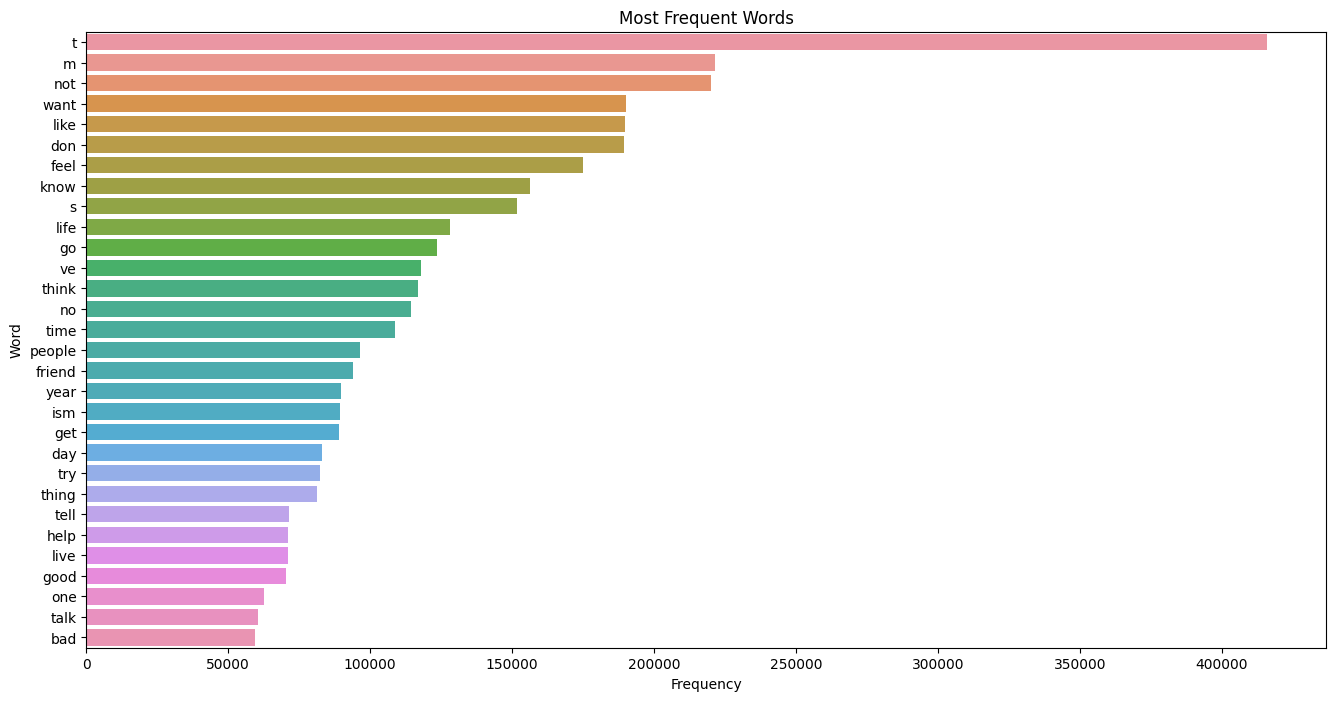

In [10]:
# Obtain word frequency 
df['cleaned_text'] = df['cleaned_text'].fillna("").astype(str)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_text'])
word_freq = pd.DataFrame(tokenizer.word_counts.items(), columns=['word','count']).sort_values(by='count', ascending=False)
# Plot bar graph for word frequency 
plt.figure(figsize=(16, 8))
sns.barplot(x='count',y='word',data=word_freq.iloc[:30])
plt.title('Most Frequent Words')
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

In [11]:
# Removed anomalous word
df['cleaned_text'] = df['cleaned_text'].str.replace('filler', '')
df['cleaned_text'] = df['cleaned_text'].str.replace('t', '')
df['cleaned_text'] = df['cleaned_text'].str.replace('m', '')
df['cleaned_text'] = df['cleaned_text'].str.replace('s', '')
df['cleaned_text'] = df['cleaned_text'].str.replace('ve', '')
df['cleaned_text'] = df['cleaned_text'].str.replace('ism', '')

In [12]:
df.to_csv('data/cleaned_SuicideDetection.csv', index=False)